# Forecast Analysis
## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

from io import StringIO

import os

## Load data

In [2]:
prediction_data = pd.DataFrame()

for file in os.listdir("prediction-data"):
    if "024" in file: # ONLY RUN ON 24 HOURS
        with open(f"prediction-data/{file}") as f:
            data = f.read()
            curr_data = pd.read_csv(StringIO(data), low_memory=False, sep=" ")
            prediction_data = pd.concat([prediction_data, curr_data])
    
prediction_data.columns = prediction_data.columns.str.strip()
prediction_data.set_index("date", inplace=True)
prediction_data.index = pd.to_datetime(prediction_data.index)
prediction_data: pd.DataFrame = prediction_data.apply(pd.to_numeric, errors='coerce')
prediction_data.loc[:, "loc_nr"] = prediction_data["loc_nr"].astype(str).str.slice(1).astype(int)
prediction_data.set_index("loc_nr", append=True, inplace=True)
prediction_data.loc[:, "mean_pred"] = prediction_data[[f"E{i + 1}" for i in range(50)]].mean(axis=1)
prediction_data.loc[:, "median_pred"] = prediction_data[[f"E{i + 1}" for i in range(50)]].median(axis=1)
prediction_data.loc[:, "min_pred"] = prediction_data[[f"E{i + 1}" for i in range(50)]].min(axis=1)
prediction_data.loc[:, "max_pred"] = prediction_data[[f"E{i + 1}" for i in range(50)]].max(axis=1)
prediction_data.loc[:, "pred_std"] = prediction_data[[f"E{i + 1}" for i in range(50)]].std(axis=1)
prediction_data.loc[:, "pred_skew"] = prediction_data[[f"E{i + 1}" for i in range(50)]].skew(axis=1)
prediction_data.loc[:, "pred_kurt"] = prediction_data[[f"E{i + 1}" for i in range(50)]].kurt(axis=1)
prediction_data.loc[:, "mode_pred"] = prediction_data[[f"E{i + 1}" for i in range(50)]].mode(axis=1, numeric_only=True).mean(axis=1)
prediction_data.loc[:, "mode2_pred"] = prediction_data[[f"E{i + 1}" for i in range(50)]].mode(axis=1, numeric_only=True).median(axis=1)
prediction_data.loc[:, "mean_det_pred"] = prediction_data[["mean_pred", "det_run"]].mean(axis=1)
prediction_data.to_hdf("prediction_data.hdf5", "prediction_data_24h")
prediction_data

,,det_run,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,mean_pred,median_pred,min_pred,max_pred,pred_std,pred_skew,pred_kurt,mode_pred,mode2_pred,mean_det_pred
date,loc_nr,,,,,,,,,,,,,,,,,,,,,
2016-04-01,260,0,0,0,0,0,0,0,0,0,0,...,0.16,0.0,0,3,0.509502,4.129082,19.937964,0.000000,0.0,0.08
2016-04-02,260,1,1,5,2,3,3,1,1,2,1,...,2.66,2.0,0,16,3.360090,2.668093,7.322484,2.000000,2.0,1.83
2016-04-03,260,34,20,8,22,19,26,19,28,12,25,...,25.90,22.0,8,75,14.570378,1.523376,2.709633,19.333333,19.0,29.95
2016-04-04,260,17,44,54,29,29,44,54,9,61,22,...,33.40,29.0,7,88,16.099182,1.028039,1.597512,36.200000,29.0,25.20
2016-04-05,260,30,18,8,24,58,36,41,30,43,25,...,31.30,31.5,8,62,15.708116,0.159005,-1.070315,8.000000,8.0,30.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,240,0,0,0,0,0,0,0,0,0,0,...,0.00,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.00
2021-04-27,240,0,0,0,0,2,0,0,1,0,1,...,0.36,0.0,0,3,0.692820,2.062579,4.056756,0.000000,0.0,0.18
2021-04-28,240,41,27,10,38,29,5,31,14,32,20,...,22.82,21.0,3,59,14.342302,0.655763,-0.160606,14.000000,14.0,31.91


In [3]:
true_weather = pd.read_hdf("weather_data.hdf5", "measured_data")
rainfall: pd.DataFrame = true_weather["RH-fix"]
daily_rainfall = rainfall.groupby([pd.Grouper(freq="D", level=0), rainfall.index.get_level_values(1)]).sum()
daily_rainfall.index.rename(["date", "loc_nr"], inplace=True)
daily_rainfall = daily_rainfall * 10
daily_rainfall

date        loc_nr
1951-01-01  240         0.0
            260        23.0
            310         0.0
1951-01-02  240         0.0
            260        25.0
                      ...  
2022-06-05  260       259.0
            310       209.0
2022-06-06  240        44.0
            260       114.0
            310       109.0
Name: RH-fix, Length: 78267, dtype: float64

## Compare data

In [4]:
combined_data = prediction_data.join(daily_rainfall)
combined_data.loc[:, "det-difference"] = combined_data["RH-fix"] - combined_data["det_run"]
combined_data.loc[:, "pred-difference"] = combined_data["RH-fix"] - combined_data["mean_pred"]
combined_data.loc[:, "med-difference"] = combined_data["RH-fix"] - combined_data["median_pred"]
combined_data.loc[:, "mode-difference"] = combined_data["RH-fix"] - combined_data["mode_pred"]
combined_data.loc[:, "mode2-difference"] = combined_data["RH-fix"] - combined_data["mode2_pred"]
combined_data.loc[:, "dp-difference"] = combined_data["RH-fix"] - combined_data["mean_det_pred"]
combined_data

,,det_run,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,mode_pred,mode2_pred,mean_det_pred,RH-fix,det-difference,pred-difference,med-difference,mode-difference,mode2-difference,dp-difference
date,loc_nr,,,,,,,,,,,,,,,,,,,,,
2016-04-01,260,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.08,0.0,0.0,-0.16,0.0,0.000000,0.0,-0.08
2016-04-02,260,1,1,5,2,3,3,1,1,2,1,...,2.000000,2.0,1.83,0.0,-1.0,-2.66,-2.0,-2.000000,-2.0,-1.83
2016-04-03,260,34,20,8,22,19,26,19,28,12,25,...,19.333333,19.0,29.95,97.0,63.0,71.10,75.0,77.666667,78.0,67.05
2016-04-04,260,17,44,54,29,29,44,54,9,61,22,...,36.200000,29.0,25.20,63.0,46.0,29.60,34.0,26.800000,34.0,37.80
2016-04-05,260,30,18,8,24,58,36,41,30,43,25,...,8.000000,8.0,30.65,14.0,-16.0,-17.30,-17.5,6.000000,6.0,-16.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,240,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.00
2021-04-27,240,0,0,0,0,2,0,0,1,0,1,...,0.000000,0.0,0.18,0.0,0.0,-0.36,0.0,0.000000,0.0,-0.18
2021-04-28,240,41,27,10,38,29,5,31,14,32,20,...,14.000000,14.0,31.91,0.0,-41.0,-22.82,-21.0,-14.000000,-14.0,-31.91


In [5]:
rmse_det = np.sqrt((combined_data["det-difference"] ** 2).mean())
rmse_pred = np.sqrt((combined_data["pred-difference"] ** 2).mean())
rmse_med_pred = np.sqrt((combined_data["med-difference"] ** 2).mean())
rmse_mode_pred = np.sqrt((combined_data["mode-difference"] ** 2).mean())
rmse_mode2_pred = np.sqrt((combined_data["mode2-difference"] ** 2).mean())
rmse_dp = np.sqrt((combined_data["dp-difference"] ** 2).mean())
f"{rmse_det=}, {rmse_pred=}, {rmse_med_pred=}, {rmse_mode_pred=}, {rmse_mode2_pred=}, {rmse_dp=}"

'rmse_det=30.887370389783708, rmse_pred=29.069563707767045, rmse_med_pred=29.03947494568891, rmse_mode_pred=29.888378105822216, rmse_mode2_pred=29.84939962012537, rmse_dp=29.461948449670306'

In [6]:
mae_det = np.abs(combined_data["det-difference"]).mean()
mae_pred = np.abs(combined_data["pred-difference"]).mean()
mae_med_pred = np.abs(combined_data["med-difference"]).mean()
mae_mode_pred = np.abs(combined_data["mode-difference"]).mean()
mae_mode2_pred = np.abs(combined_data["mode-difference"]).mean()
mae_dp = np.abs(combined_data["dp-difference"]).mean()
f"{mae_det=}, {mae_pred=}, {mae_med_pred=}, {mae_mode_pred=}, {mae_mode2_pred=}, {mae_dp=}"

'mae_det=13.318059299191376, mae_pred=12.933516621743061, mae_med_pred=12.380233602875112, mae_mode_pred=12.161443614686199, mae_mode2_pred=12.161443614686199, mae_dp=12.868300089847255'

In [27]:
import time
def rmse(true, predicted):
    return np.sqrt(((true - predicted) ** 2).mean())

def mae(true, predicted):
    return np.abs(true - predicted).mean()

# def smae(true, predicted):
#     return (np.abs(true - predicted)/((np.abs(predicted) + np.abs(true))/2)).mean()

# def maape(true, pred):
#     return np.arctan(np.abs((true - pred + 0.1)/(true + 0.1))).mean()

def meae(true, pred):
    return np.median(np.abs(true - pred))

def me(true, pred):
    return (true - pred).mean()

# def mrae(true, pred):
#     return np.sqrt(np.abs(true - pred)).mean()

def malipe(true, pred):
    return (np.abs(true - pred)/np.maximum(true, 0.5)).mean()

def get_error_statistics(true, pred, bins=10):
    time_ = int(time.time())
    print(f"RMSE: {rmse(true, pred)}")
    print(f"MAE: {mae(true, pred)}")
    print(f"MeAE: {meae(true, pred)}")
    print(f"ME: {me(true, pred)}")
    print(f"MALiPE: {malipe(true, pred)}")

    print("Histogram:")
    plt.hist(true - pred, bins=bins, density=True, range=[1.5 * np.quantile(true - pred, 0.05), 1.5 * np.quantile(true - pred, 0.95)])
    plt.title("Error histogram")
    plt.xlabel("Error (10 mm)")
    plt.ylabel("Frequency")
    plt.savefig(f"plots/{time_}ErrorHist.png")
    plt.show()

    print("Scatter plot:")
    plt.scatter(true, true-pred)
    plt.title("Error Scatter Plot")
    plt.xlabel("True Rainfall (10 mm)")
    plt.ylabel("Error (10 mm)")
    plt.ylim([-np.abs(true - pred).max() * 1.1, np.abs(true - pred).max() * 1.1])
    plt.savefig(f"plots/{time_}ScatterPlot.png")
    plt.show()

    print("Error-Quantile plot:")
    x = np.linspace(0.025, 0.975, 1000)
    plt.plot(x, np.quantile(true - pred, x))
    plt.title("Error Quantile Plot")
    plt.xlabel("Quantile")
    plt.ylabel("Error (10mm)")
    plt.savefig(f"plots/{time_}ErrorQuantile.png")
    plt.show()

RMSE: 30.887370389783708
MAE: 13.318059299191376
MeAE: 4.0
ME: -1.1962264150943396
MALiPE: 3.6976277846403582
Histogram:


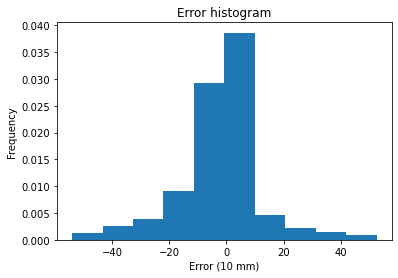

Scatter plot:


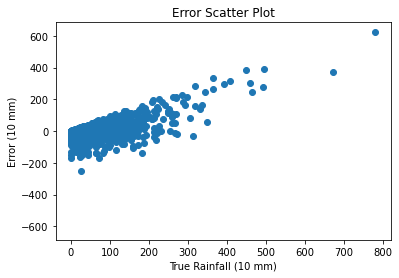

Error-Quantile plot:


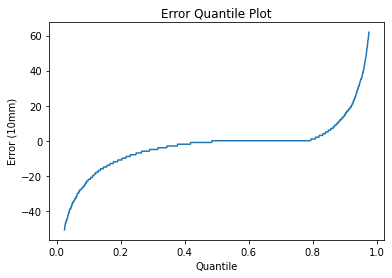

In [28]:
get_error_statistics(combined_data["RH-fix"], combined_data["det_run"])

RMSE: 29.069563707767045
MAE: 12.933516621743061
MeAE: 4.52
ME: -0.8660233602875088
MALiPE: 4.437892902090497
Histogram:


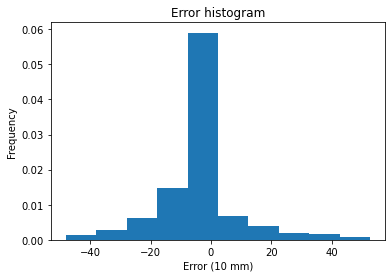

Scatter plot:


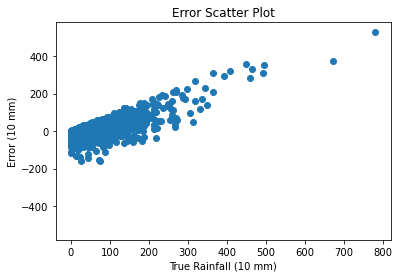

Error-Quantile plot:


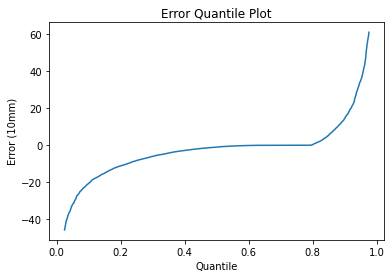

In [29]:
get_error_statistics(combined_data["RH-fix"], combined_data["mean_pred"])

RMSE: 29.03947494568891
MAE: 12.380233602875112
MeAE: 4.0
ME: 0.5331536388140161
MALiPE: 3.5712491589592625
Histogram:


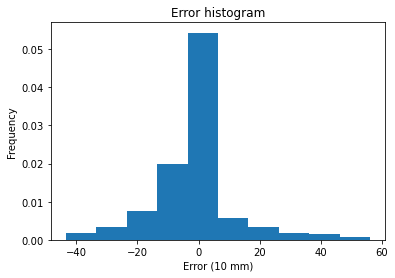

Scatter plot:


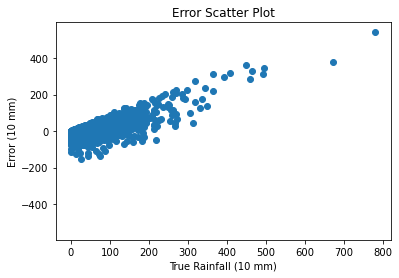

Error-Quantile plot:


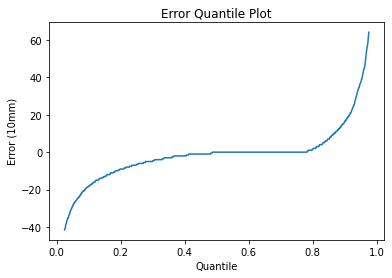

In [30]:
get_error_statistics(combined_data["RH-fix"], combined_data["median_pred"])

RMSE: 29.888378105822216
MAE: 12.161443614686199
MeAE: 3.0
ME: 1.8548778077268637
MALiPE: 2.8398989477738157
Histogram:


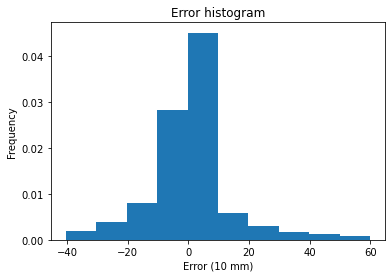

Scatter plot:


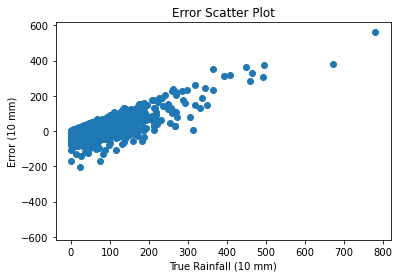

Error-Quantile plot:


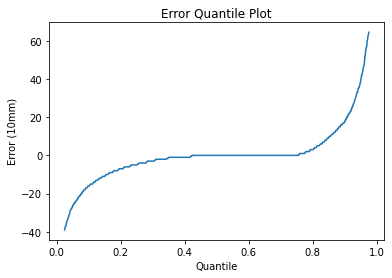

In [31]:
get_error_statistics(combined_data["RH-fix"], combined_data["mode_pred"])

## Correlation deterministic and predicted

In [9]:
prediction_data[["mean_pred", "det_run", "median_pred", "mode_pred", "mode2_pred"]].corr()

,mean_pred,det_run,median_pred,mode_pred,mode2_pred
mean_pred,1.000000,0.955258,0.996995,0.977414,0.975106
det_run,0.955258,1.000000,0.955954,0.942353,0.939742
median_pred,0.996995,0.955954,1.000000,0.983236,0.981600
mode_pred,0.977414,0.942353,0.983236,1.000000,0.998856
mode2_pred,0.975106,0.939742,0.981600,0.998856,1.000000


In [10]:
import datetime
combined_data.loc[datetime.datetime(2021, 1, 1)]

,det_run,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,mode_pred,mode2_pred,mean_det_pred,RH-fix,det-difference,pred-difference,med-difference,mode-difference,mode2-difference,dp-difference
loc_nr,,,,,,,,,,,,,,,,,,,,,
260,4,2,7,1,6,0,1,2,6,2,...,1.0,1.0,3.49,0.0,-4.0,-2.98,-2.0,-1.0,-1.0,-3.49
310,20,10,8,11,8,9,17,10,14,28,...,8.0,8.0,15.73,16.0,-4.0,4.54,7.0,8.0,8.0,0.27
240,10,4,10,3,5,2,5,3,13,3,...,4.0,4.0,8.09,5.0,-5.0,-1.18,0.0,1.0,1.0,-3.09
